# sentiment analysis with transfer learning using fastai

In this computational essay I perform a **sentiment analysis**, also known as a **text classification problem**. Sentiment analysis is an application in the broader field of **natural language processing** (NLP) in the even broader field of **deep learning**. 

The goal of this essay is to explore the conceptual and programmatic framework for performing similar NLP problems using [fastai](https://www.fast.ai/). It assumes some basic understanding of the terminology and ideas behind deep learning.

For this project I have amassed my own data set which consists of typed notes provided by a potential customer to a sales professional while scheduling an estimate appointment. The data was joined with a binary indicator of whether a sale was made within the next 60 days. 

This essay proceeds as follows:

1.   Preparing the data  
    i.   Importing the Data  
    ii.  Data Partitioning  
    iii. Data Upsampling  
    iv.  Transforming Data
2.   Training the Models  
    i.  The Language Model  
    ii. The Classification Model
3.   Model Performance  
    i.   Confusion Matrix  
    ii.  ROC Curve  
    iii. Prediction



# Preparing the Data

##Importing the Data

The data is exported from a proprietary CRM database. Because the database lies under a software GUI the options for export are limited by the overlaying application. Therefore the data has been exported in a structured report format in a spreadsheet. Excel macros have been used to automate the scraping and cleaning of the data. 


The full data set will be imported from my personal Google Drive account which uses two-factor authentication and is therefore not accessible for replication. A sample of the data has been included in this project's GitHub repo at https://github.com/blakeobeans.

The analysis will be carried out in a Google Colab notebook which runs Python 3 with a GPU accelerator.

In [0]:
from fastai.text import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Work/Data Science/nlp project/transformed data'
os.chdir(path)
df=pd.read_csv("data.csv")
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,label,text
0,positive,05/03/16 Mr. called for Alex to give him a c...
1,positive,Gave verbal quote for new ducting with design...
2,positive,"Q COMPLETE XC16, $13,800 FOLLOW UP WITH CUST ..."
3,positive,Quoted 3250.00 to do dampers with zone board....
4,positive,"sold 3.5 ton 15 seer gaspack for 11,200.00 cu..."


A sample of the data is above. The first column, **label,** indicates whether the sale was successful or not. The second column, **text**, contains the text  of the notes.

## Data Partitioning

The unfortunate nature of a sales call is that there are often more failures than successes. Therefore the data will be **upsampled** (duplicating some positive cases to achieve a 50/50 split).

In [5]:
df['label'].value_counts()

negative    1655
positive    1067
Name: label, dtype: int64

The data first needs to be first **partitioned** (ie. split into training and test sets) then upsampled. As an aside: an analysis was first carried out without upsampling. The results were poor- the model was a **naive classifier** meaning that all cases were classified as negative. Then the analysis was carried out with data upsampling but prior to partitioning. This time the model AUC was 99% because the model had seen the exact same data in both the training and test sets. Then, the model upsampled and partitioned. While the language model worked well, and the model had a 70% AUC, the classification model incorrectly predicted negative results with new observations. The final model used stratification but not upsampling, which achieved expected results across all categories.

### UPDATE: DATA IS NOW STRATIFIED RATHER THAN UPSAMPLED. THIS WORKS BETTER.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, stratify = df['label'], test_size=0.2)

## Transforming the Data

The text classififcation uses two different models: a **learning model** and a **classification model**. Models will be explained in the next section. 

For each model the data is converted into **databunch** object. It contains everything you need to build the model- variables, labels, etc. 

In [7]:
data_lm = TextLMDataBunch.from_df(path, train_df = train, valid_df = test) #databunch object for language model

When building the databunch for the classifier, we pass the vocabulary learned in the language model. We also set the **batch size**, which represents how many cases (observations) pass through the model at a time. A larger batch size leads to better approximations of the gradient but is constrained by GPU size.

In [8]:
data_clas = TextClasDataBunch.from_df(path, train_df = train, valid_df = test, vocab=data_lm.train_ds.vocab, bs=64) #databunch object for classification model

You only need to build these once. Since it can be timely, it is best practice to save them.

In [0]:
#saves to existing directory
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

# Training the Models

In fastai, there are three steps to building a sentiment analysis model.  
 
1.   We begin by downloading the pre-trained **AWD-LSTM language model** (*ASGD Weight-Dropped Long Short-Term Memory Networks*). This model was trained on the [WikiText 103 dataset](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) and therefore it basically understands English.
2.   We then fit this model to our data. In other words, we feed our data into the existing AWD-LSTM language model, which updates and fine-tunes the parameter values in order to understand the nuances of our data. This process is called **transfer learning**.    
3.   We load the **encoder** from the language model into our **classification model**, the *Universal Language Model Fine-tuning for Text Classification* (**ULMFiT**) model. 

We then measure the accuracy of the classification model on the test data, perform diagnostics, prediction, etc.


## Model 1- Language Model

fastai uses **learners** to train language models, in this case *language_model_learner()*. 

Inputs to the function are the databunch, the AWD-LSTM architecture, *drop_mult* and optional *callbacks_fns*.

*Drop_mult* is a method of regularization commonly known as **drop_out**. Drop out randomly resets some parameters in the layer's matrix so that no layer memorizes any of the inputs. The recommended default is 0.5. If the model is overfitting early in the training then drop out can be increased. 

*Callbacks* control how the model is trained. *EarlyStoppingCallback* stops training the model when a specified accuracy metric is maximized or minimized. In this case, the model will stop when **validation error** (the error in prediction on the test data) is minimized within a range set by the other methods of the callback function. This will help prevent overfitting on the test data. 

In [10]:
from fastai.callbacks import *
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5, metrics = [accuracy], callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3)]) #AWD_LSTM downloaded from AWS

Prior to training our model, we set the **learning rate**. The learning rate sets the step size on the gradient descent algorithm. Larger learning rates may overshoot the minimum while small learning rates are too slow to descend.

The *learning rate finder* will help suggest potential learning rates. It works by increasing the learning rate after each batch while measuring the loss or error. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 7.59E-02


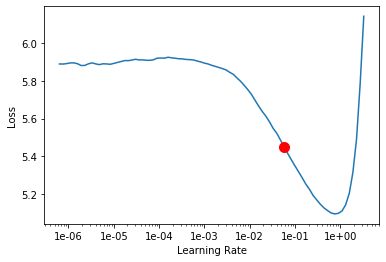

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True) 

The model is "learning" with LR's between 1e-03 to 1. However, we don't want to pick the minimum as our learning rate because we can potentially overshoot to the steep edge on the right side. Instead, we want to try different learning rates along the slope up to the minimum. There are various rules of thumb but it is recommended to try different LR's and use what best reduces validation error.

***Now we're ready to train the model.*** fastai recommends using the *.fit_one_cycle()* method which is both fast and more accurate than just using *.fit()*. 

*cycle_length* is the number of **epochs** or full runthroughs of the data. After each cycle the parameters are adjusted according to the loss function. Because I've set the callback in the learner to stop when validation loss is minimized, the exact choice of cycle length is not important- it just needs to be long enough to minimize the *valid_loss*.

*max_lr* is the learning rate selected in the previous section. Because fastai adjusts the learning rate within each cycle (called **cyclical learning rates**), the learning rate we select is actually the maximum used in training.

Closely related to the learning rate is the **momentum** at which the learning rate adjusts between its minimum and its maximum in a given cycle. For a high (fast) learning rates, we want slower momentum and vice versa. *Moms* is set at between .8 and .7.

Finally, our **weight decay** is a method of regularization applied as a coefficient to the loss function. It is relatively small (0 is the max). Smaller weight decay is compatible with shallower networks. This metric may need to be adjusted and experimentation is encouraged. The ideal weight decay can usually be discerned after only a few epochs.

Callback *SaveModelCallback* to save model at every epoch. It will save in the working directory and the files can be quite large (300 MB each)!

In [13]:
learn.purge() #resets model. Use when testing various LR's and WD's
learn.fit_one_cycle(cyc_len = 20, max_lr = 1e-2, wd=1e-4, moms=(0.8, 0.7), callbacks = [SaveModelCallback(learn, every='epoch', monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,5.612532,5.080757,0.186851,00:14
1,5.007787,4.125484,0.250873,00:14
2,4.371666,3.585626,0.316660,00:14
3,3.868594,3.301912,0.349777,00:14
4,3.497864,3.142801,0.364387,00:14
5,3.233757,3.062544,0.376765,00:14
6,3.027821,3.000098,0.382792,00:13
7,2.872311,2.975277,0.387804,00:13
8,2.756453,2.961407,0.391822,00:14
9,2.656314,2.954492,0.392512,00:13


Epoch 14: early stopping


The model stopped early at epoch 13 because *valid_loss* began to increase. This indicates that the model is beginning to overfit the training data. The early stopping rule does not exactly minimize the validation loss, rather, it stops when it begins to increase by a certain amount. This is evident as the lowest validation loss is actually in epoch 12. We'll save that model as our best language model so far. 

In [0]:
%%capture
learn.load("bestmodel_12")
learn.save("learner_one_layer", return_path = False) #save previous run

Once we train our model, we may want to fine-tune it by **un-freezing** some or all of the deeper layers. We typically don't need to do a lot of parameter adjustment on the deeper layers because the language model is pre-trained through transfer learning. To use an analogy, the pre-trained deeper layers in the language model shouldn't "learn" that much more about English from our data specifically. It is best practice to use **discriminative learning rates** in training the un-frozen model. DLR's use smaller learning rates for deeper layers because they don't need much adjustment and vice versa.  



In [15]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4, 1e-1), wd=1e-4, moms=(0.8, 0.7), callbacks = [SaveModelCallback(learn, every='epoch', monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,2.366554,2.931534,0.397240,00:18
1,2.386893,2.955007,0.395455,00:18
2,2.458000,3.011015,0.386546,00:18
3,2.502766,3.002721,0.395617,00:18


Epoch 4: early stopping


We can see we have the lowest *valid_loss* in epoch 0. Since it's the best model thus far, we'll load this model then save it as our **encoder** portion of the classifier model. Programmatically, the entire point of training so far has been to create this encoder.

In [0]:
%%capture
learn.load("bestmodel_0")
learn.save("learner_multi_layer", return_path = False)
learn.save_encoder('ft_enc')

We'll also export the language model for production purposes.

In [0]:
learn.export('language_model.pkl')

Now we can see how well our language model is predicting the next word in the sentence about 40% of the time. Lowering *temperature* will make the texts less randomized.

In [18]:
learn.predict("interested in", n_words=30, temperature=0.5)

'interested in HVAC replacement . HVAC is 30 y / o , Cust states that she is looking for something more efficient . Home is single story ,'

## Model 2- Classification Model

Now we're ready to build our ULMFiT classification model which predicts whether a job is sold given the notes on the sales call. 

### Set-up (classifier)

Recall that we set up the databunch, *data_clas*, already. The databunch pre-processes the original data through **tokenization**. Tokenization slightly restructures the English language. Most tokens are just full words, but also include punctuation and document formatting (whose tokens start with [xx___](https://docs.fast.ai/text.transform.html#Tokenizer).)

In [19]:
data_clas.show_batch(1)
#data_clas.vocab.itos[:20] #top 20 words

text,target
"xxbos xxmaj tech - lead xxmaj kody . xxmaj estimate for replacement of 3rd system in customer 's guest house . xxup kjb5 / 22 / 19 xxmaj ac tune up x2 complete , checked filter , tested refrigerant , tested temp split , tested amps , tested mfds , tested volts , tested electrical connections , checked for loose connections , visually inspected contactor , verified condensate draining ,",positive


**Numericialization** replaces the tokens with numeric id's. 

In [20]:
data_clas.train_ds[0][0].data[:10]

array([  2,  58,  10,  48,  10,  38, 899, 260, 124, 143])

We'll set up our learner, *text_classifier_learner()* and load our encoded language learner from the previous section.

In [0]:
%%capture
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy], callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3)])
classifier.load_encoder('ft_enc')

We can review our neural network by calling the *.model* method. We can see that the model is a **recursive neural network** meaning that it "remembers" previous cases when training on a given case. The first part of the model is the AWD_LSTM encoder that had been updated with our data along with a dropout layer. There are also hidden layers for weighted drop-out. 

The second part of the model is our classifier, which uses a ReLU activation function, batch-level normalizers, and two drop-out layers.

In [22]:
classifier.model
#classifier.summary() #NN summary

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(3344, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(3344, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

Just like with the learning model, we begin by finding our max learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 4.37E-02


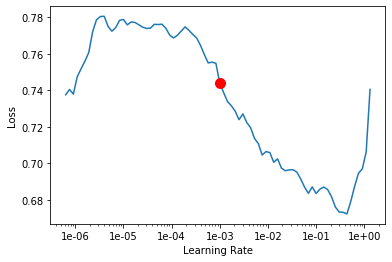

In [23]:
classifier.lr_find() 
classifier.recorder.plot(suggestion=True)

***Now we're ready to train the classifier.*** All of the same rules around the hyperparameters apply, so we can move through this section more quickly.

In [0]:
classifier.purge() #resets model. Use when testing various LR's and WD's
classifier.fit_one_cycle(cyc_len = 20, max_lr = 1e-3, wd=1e-4, moms=(0.8, 0.7), callbacks = [SaveModelCallback(classifier, every='epoch', monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,0.494309,0.528915,0.770642,00:09
1,0.520714,0.561179,0.754128,00:09
2,0.548399,0.646414,0.675229,00:09
3,0.548988,0.483441,0.776147,00:08
4,0.565085,0.608205,0.737615,00:09
5,0.573311,0.573727,0.724771,00:08
6,0.572394,0.551518,0.737615,00:09


Epoch 7: early stopping


Epoch 3 had the lowest *valid_loss**, so let's save this as our single-layer classifier.

In [0]:
%%capture
classifier.load("bestmodel_3") #.463
classifier.save("classifier_one_layer", return_path = False)

Unfreezing layers in the classifier.


In [24]:
classifier.unfreeze()
classifier.fit_one_cycle(20, slice(1e-5, 1e-1), wd=1e-4, moms=(0.8, 0.7), callbacks = [SaveModelCallback(classifier, every='epoch', monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,0.596623,0.501437,0.774312,00:21
1,0.545063,0.592956,0.748624,00:23
2,0.535843,0.475313,0.788991,00:22
3,0.509859,0.461358,0.807339,00:21
4,0.486546,0.529811,0.794495,00:22
5,0.457801,0.470848,0.792661,00:22
6,0.439016,0.437326,0.787156,00:20
7,0.380786,0.605942,0.798165,00:21
8,0.329045,0.831137,0.788991,00:20
9,0.284055,0.930187,0.788991,00:20


Epoch 10: early stopping


We had the lowest *valid_loss* with the multi-layer model, particularly epoch 6. Therefore let's reload and test the performance of this model.

In [0]:
%%capture
classifier.load("bestmodel_6")
classifier.save("classifier_multi_layer", return_path = False) #save previous run

We'll also export the classifier model for production purposes.

In [0]:
classifier.export('classifier_model.pkl')

# Model Performance

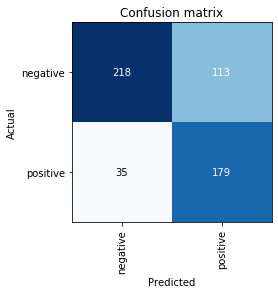

In [26]:
from fastai.vision import *
preds,y,losses = classifier.get_preds(with_loss=True)
interp = TextClassificationInterpretation(classifier, preds, y, losses)
interp.plot_confusion_matrix()

Given the class imbalance, the sensitivity and specificity can be improved by adjusting the thresholds on the confusion matrix, or we can just build an ROC curve.

In [0]:
from sklearn import metrics
dataframe = preds.numpy()
dataframe = pd.DataFrame(dataframe)
string = dataframe.iloc[:,0]
probs = string.to_numpy()
actual = y.numpy()
fpr, tpr, thresholds = metrics.roc_curve(actual, probs)
roc_auc = metrics.auc(fpr, tpr)
roc_auc = 1-roc_auc #had to do this...

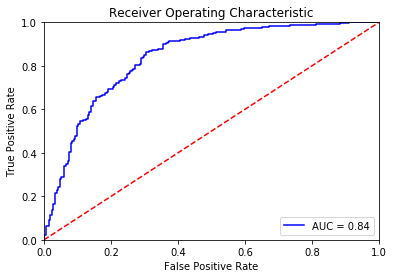

In [28]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(tpr, fpr, 'b', label = 'AUC = %0.2f' % roc_auc) #switched tpr and fpr...
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Now we can use the model to predict whether a sale will be made based on *any* input text.

In [29]:
classifier.predict("interested in ductwork friend of Patty's SOLD SOLD SOLD heard us on radio")

(Category positive, tensor(1), tensor([0.0136, 0.9864]))